### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2021
Búsqueda y Recomendación para Textos Legales

Mentor: Jorge E. Pérez Villella

# Práctico Análisis y Visualización

Integrantes:

### Objetivos:

Normalizar el corpus generado en el práctico anterior, teniendo en cuenta los siguientes aspectos:

* tokenización, 
* pasar a minúsculas, 
* separar puntuación, 
* stemming y lematización, 
* eliminar stopwords (o no), 
* eliminar las palabras con frecuencia menor a n. 

Analizar las palabras más frecuentes de todo el corpus, por fuero y de 5 documentos. Compararlo con el resultado obtenido en el ejercicio anterior. Se observa algún cambio significativo?

Hacer una explicación con ejemplos tomando algunas palabras al azar entre lo que es stemming y lemmatizing para entender que nos da cada uno de estos procesos y cual es conveniente utilizar en cada caso.

Opcional:

* Investigar que es Segmentación y compararlo con Tokenización. Ejemplificar con un documento.
* Investigar NER (Named Entity Recognition - Reconocimiento de Entitades Nombradas). Buscar las Entidadas Nombradas mas frecuentes en todo el corpus y por fuero. 


Fecha de Entrega: 4 de julio de 2021

In [11]:
#!conda install -y -c conda-forge spacy=3.0.6

Se valida que spacy este instalado de manera correcta. Se valida además que se tenga instalado el lenguaje de interés, en este caso ES

In [88]:
!python -m spacy validate

✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.0.6) =================
ℹ spaCy installation:
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/spacy

NAME              SPACY            VERSION                            
es_core_news_md   >=3.0.0,<3.1.0   3.0.0   ✔
en_core_web_sm    >=3.0.0,<3.1.0   3.0.0   ✔



In [89]:
#!python -m spacy download es_core_news_md

In [2]:
import pandas as pd
import spacy
import datetime
from spacy.tokens.doc import Doc
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams
import seaborn as sns
import re
sns.set()

import lib.nlp_cba as nlp_cba
import lib.graph_cba as graph_cba

In [3]:
print(spacy.__version__)

3.0.6


Las siguiente variables se utilizan para configurar la notebook, como por ejemplo nombres de archivos a cargar, a grabar, etc. Cada una de las variables tiene los comentarios correspondientes indicando que configuración permiten.

In [4]:
#Nombre con el cual se graba el data frame corpus de todas las sentencias. Cada sentencia es una fila
corpus_file_name = "corpus.csv"

#Nombre con el cual se graba el data frame que tiene el corpus sumarizado por fuero. Todo el texto de las sentencias de un
# fuero esta en una sola fila
agregated_corups_df_file_name = "agregated_corpus.csv"

#Indica si se levantan datos desde archivo pickle o no. 
#En archivo pickle contiene serializado el resultado de correr el 
#pipleline de spacy. Es decir, tiene toda la lista de tokens 
#generados por spacy.

load_from_pickle = True

#Indica si se graba o no el corpus luego de ser normalizado
save_cleaned_corpus = False

In [5]:
print (f"El data frame corpus_df se carga desde el archivo {corpus_file_name}")
corpus_df = pd.read_csv(corpus_file_name)

El data frame corpus_df se carga desde el archivo corpus.csv


In [6]:
print (f"El data frame agregated_corups_df se carga desde el archivo {agregated_corups_df_file_name}")
agregated_corups_df = pd.read_csv(agregated_corups_df_file_name)

El data frame agregated_corups_df se carga desde el archivo agregated_corpus.csv


In [7]:
corpus_df.head()

,text,classifier,id
0,datos de la causa sede ciudad de córdoba. de...,Documentos/MENORES,4de122c24ab1606c9d67f4ff9e656143
1,unívoco 18900 fecha 04/04/2016 materia niñe...,Documentos/MENORES,1f9cdcb2c2596656b540c1271fc2d843
2,13/03/2013 juzgado de la niñez juventud y vio...,Documentos/MENORES,17dcae14592fc6e87680ccb4251d9395
3,los autos caratulados a. a. - denuncia...,Documentos/MENORES,4b3ae58648b6267ebb332feec8002588
4,juzg. de niñez adolescencia y violencia famil...,Documentos/MENORES,1316026beaa1d7e6530bdfe7e54f7b5c


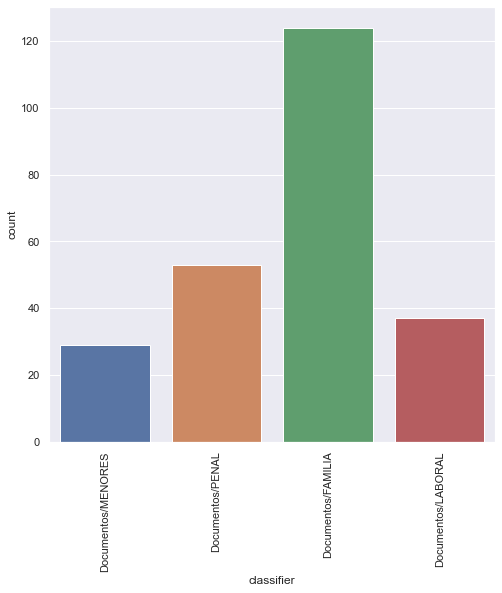

In [8]:
fig, axes = plt.subplots(1, 1 , figsize=(8, 8))

sns.countplot(x = corpus_df['classifier'] , ax = axes )

axes.set_xticklabels(axes.get_xticklabels(),rotation=90)
plt.show()

Se puede observar que el data set esta muy desbalanceado . El desbalanceado para ciertos tipos de modelos y arquitecturas de redes neuronales es un problema. Se debe analizar si es posible: 

- Obtener más documentos de manera tal de poder tener un data set más balanceado.
- Generar de manera artificial documentos
- Utilizar documentos de otra temática, lo que se busca en definitiva a nivel general es buscar documentos por similitud

In [9]:
agregated_corups_df.head()

,text,classifier
0,datos de la causa sede ciudad de córdoba. de...,Documentos/MENORES
1,sala penal - tribunal superior protocolo de s...,Documentos/PENAL
2,auto número sesenta y seis córdoba cinco de...,Documentos/FAMILIA
3,sala laboral - tribunal superior protocolo de...,Documentos/LABORAL


El data frame agregated_corpus tiene una fila por cada fuero. En el campo text se encuentra todo el texto de todos los documentos de un fuero. Este data frame es levantado desde un archivo generado en el práctico anterior.

## Nomalización de Texto

### Lemmatazing y Stemmig

El Stemming y Lemmatization son técnicas de normalización de texto (o algunas veces llamadas normalización de palabras) en el campo del procesamiento del lenguaje natural que se utilizan para preparar texto, palabras y documentos para su posterior procesamiento. El Stemming y Lemmatization se han estudiado y desarrollado algoritmos en Ciencias de la Computación desde la década de 1960.

Referencia: https://www.datacamp.com/community/tutorials/stemming-lemmatization-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1000126&gclid=Cj0KCQjwlMaGBhD3ARIsAPvWd6iVkFDMxcYxY31g8B5Oi0dD41si5dfJZVNf0UIPEsAilax8c8zMVlsaArk5EALw_wcB

#### Stemming

Stemming es el proceso de reducir la inflexión de las palabras a sus formas de raíz, de forma tal de asignar un grupo de palabras a la misma raíz, **incluso si la raíz en sí no es una palabra válida en el idioma**. 

En gramática, la inflexión es la modificación de una palabra para expresar diferentes categorías gramaticales como tiempo, caso, voz, aspecto, persona, número, género y estado de ánimo. Una inflexión expresa una o más categorías gramaticales con un prefijo, sufijo o infijo, u otra modificación interna como un cambio de vocal.

spaCy no contiene ninguna función para realizar stemming, ya que se basa únicamente en lemmatazing. Aclaramos esto, puesto que nosotros vamos a utilizar spaCy. Esto esta detallado más adelante. 

En el siguiente link  (https://github.com/explosion/spaCy/issues/327) se puede ver un interesante debate del porque spaCy no implementa ningun Stemmer. 

#### Lemmatazing


Lemmatazing, a diferencia de Stemming, reduce las palabras flexionadas adecuadamente **asegurando que la palabra raíz pertenezca al idioma**. En lemmatazing, la palabra raíz se llama lema. Un lema (plural lemas o lemas) es la forma canónica, la forma de diccionario o la forma de cita de un conjunto de palabras.


<img src="images/stemmingvslemma.png">


#### Principales diferencias

 - Stemming y lemmatazing generan la forma raíz de las palabras flexionadas. La diferencia es que en Stemming, la raíz puede no ser una palabra real, mientras que lema es una palabra del idioma real.<br><br>

 - Stemming sigue un algoritmo con pasos para realizar en las palabras lo que lo hace más rápido. Mientras que, en lemmatazing, usa un corpus de palabras para producir lema, lo que lo hace más lento que Stemming. 

#### Entonces, ¿cuándo usar qué?

Los puntos anteriores muestran que si se enfoca la velocidad, entonces se debe usar Stemming, ya que lemmatizing escanean un corpus que consume tiempo y procesamiento. Será el tipo de aplicación en la que estemos trabajando la que decida si se deben usar lemmatizeing o stemming. Si está creando una aplicación de lenguaje en la que el lenguaje es importante, debe usar lemmatazing, ya que usa un corpus para hacer coincidir las formas raíz.


Referencia : https://stackabuse.com/python-for-nlp-tokenization-stemming-and-lemmatization-with-spacy-library

## Que vamos a utilizar para realizar la normalización?
Para hacer la normalización de texto vamos a utilizar Spacy y clases / funciones desarrolladas por nosotros.  

Vamos a utilizar spaCy puesto que uno de los objetivos de la mentoria es el de utilizar y comparar diferentes librerías (por ejemplo spaCy, Nltk) para realizar procesamiento de lenguaje natural.

Los modelos de Spacy de procesamiento de lenguaje natural permiten analizar un texto y extraer información tanto del texto como de las predicciones del modelo sobre su significado por el contexto. 

Referencia: https://todobi.com/introduccion-a-spacy/

Spacy divide el texto procesado en tokens, estos tokens pueden ser palabras y/o signos de puntuacion. Cara token de Spacy tiene ciertos atributos e informacion como por ejemplo: 

-	Texto del token: palabra y/o signo de puntuación
-	Tipo: Indica si la palabra es un verbo, adjetivo, etc.
-	Dependecia sintáctica con otro token

La colección de tokens de texto, forman un Doc. Por ejemplo, si leemos todo el texto de un archivo y lo procesamos con Spacy, como resultado obtendremos, un objecto del tipo Doc, el cual contiene una lista / colección de tokens.

Referencia: https://stratebi.es/todobi/Jun20/Introduccion_SpaCy.pdf


Los resultados obtenidos respecto a la utilización de Spacy serán contrastados con los resultados obtenidos a partir del uso de Nltk. Nltk será utilizado por otro equipo.

Cargamos el lenguaje español en spacy. Previamente validamos que el lenguaje este instalado en Spacy

In [10]:
spacy_nlp = spacy.load("es_core_news_md") 
spacy_nlp.max_length = 5000000

Doc.set_extension('document_id', default=False, force=True)
Doc.set_extension('classifier', default=False, force=True)

Vemos las STOP_WORDS que viene definidas por defect

In [350]:
#spacy.lang.es.stop_words.STOP_WORDS

Agregamos stop words que consideramos necesarias eliminarlas del texto

In [351]:
# Stop_words que no estan contempladas en Spacy y consideramos necesario sacarlas

customs_stop_words = ['y' , 'a', 'e' , 'o' , 'u' , 'n.' , 'nª' , 'nº']


for custom_stop_word in customs_stop_words:
    spacy_nlp.vocab[custom_stop_word].is_stop = True
    spacy.lang.es.stop_words.STOP_WORDS.add(custom_stop_word)

#spacy.lang.es.stop_words.STOP_WORDS

Implementamos clases que permitan filtrar y transformar datos de los documentos. Estas clases usan mayoritariamente clases y funciones de Spacy.

Se crean las siguientes clases:

-	Filter: Todas las clases terminadas en Filter se encargan de indicar si un token de texto se debe eliminar o no del texto. Cuando el filtro devuleve True, el token se elimina.<br><br>
-	Transformer: Todas las clases terminadas en Transformer, se encargan de tranformar un token. Algunas transformaciones puede ser: Pasar a minúscula, usar un Lema, entre otros.<br><br>
-	SpacyTextNormalizer: Esta clase funciona como un pipeline. Se le pasan listas de vectores de Filter y Transformer y los aplica sobre le texto. Primero se ejecutan los Filter y luego los Transformers. Los Filter y Transformer se ejecutan en el orden que aparecen en las listas.

In [352]:
class RemoveStopWordsFilter:
    def execute(self, word):
        return word.is_stop 

class RemovePuntctuationFilter:
    def execute(self, word):
        return word.is_punct
    
class RemoveSpaceFilter:
    def execute(self, word):
        return word.is_space

class RemoveNumberFilter:
    def __init__(self, words, token_memory_ticks = 3 ):
        self.words = words
        self.token_memory_ticks = token_memory_ticks
        self.ticks = 0
        
    def execute(self,word):
        is_number = False
        
        if word.lower_ in self.words:
            self.ticks = self.token_memory_ticks
            return is_number
        
        self.ticks = self.ticks - 1
        #print (f"palabra : {word.lemma_}")
        #is_number = (word.like_num or word.is_digit or word.lemma_.isnumeric())
        
        is_number = word.lemma_.isnumeric()
        
        #print (f" Palabra {word.lemma_} Ticks {self.ticks}")
        result = is_number and self.ticks < 0
        
        if result:
            #print (f"word {word.lemma_}")
            #print (f"ticks {self.ticks}")
            
            self.ticks = 0 
            
        return result
        
    
class RemoveDateFilter:
    def execute(self,word):
        return re.search("^([1-9]|0[1-9]|1[0-9]|2[0-9]|3[0-1])(\.|-|/)([1-9]|0[1-9]|1[0-2])(\.|-|/)([0-9][0-9]|19[0-9][0-9]|20[0-9][0-9])$|^([0-9][0-9]|19[0-9][0-9]|20[0-9][0-9])(\.|-|/)([1-9]|0[1-9]|1[0-2])(\.|-|/)([1-9]|0[1-9]|1[0-9]|2[0-9]|3[0-1])$", word.lemma_)
            
class ToLowerCaseTransformer:
    def transform(self, word):
        return word.lower_
    
class ToLemaTransformer:
    def transform(self, word):
        return mapMultipleCharsProcessor.process(word.lemma_ , chars_replace)
    

In [353]:
class SpacyTextNormalizer:
    def __init__(self):
        
        self.filters = []
        self.transformers = []
        self.documents = []
        
    def fit(self , spacy_tuples):
        self.documents = []
        for doc,context in spacy_tuples:
            
            doc._.document_id = context["document_id"]
            doc._.classifier = context["classifier"]
            self.documents.append(doc)
        
        
    def normalize(self, filters = [], transformers = []):
        documents = []
        for doc in self.documents:
            words = []
            
            for word in doc:
                remove_token = False

                for filter in filters:
                    remove_token = filter.execute(word)
                    #if isinstance (filter, RemoveNumberFilter ): 
                        #print (f"Filtro {filter}. Palabra {word}. Se debe eliminar {remove_token}")
                    
                    if remove_token: 
                        break
        
                if not remove_token:
                    
                    transformed_res = []
                    transformed_res.append(word)
                    
                    for transformer in transformers:
                        transformed_res.append(transformer.transform(word))
                        
                    words.append(transformed_res)       
        
            documents.append(( doc ,words))
        
        return documents

Esta clase reemplaza los caracteres según lo que indica el diccionario replace_chars.

In [354]:
class MapMultipleCharsProcessor:

    def process(self, text , replace_chars):
        
        for ch in replace_chars:
            text = text.replace(ch[0],ch[1])

        
        return text

Timer: Esta clase permite medir el tiempo transcurrido entre que se hace un start y stop. Notar que a diferencia de %%time, Timer permite tomar tiempos en bloques de código especificos dentro de una celda.

In [355]:
class Timer:
    
    def start(self):
        self.start_ = datetime.datetime.now()
        
    def stop(self):
       
        self.stop_ = datetime.datetime.now()
        print (f"Tiempo de procesamiento: {self.stop_ - self.start_}")

    def print_stats(self):
        print (f"Tiempo de procesamiento: {self.stop_ - self.start_}")

timer = Timer()

Hemos visto que los documentos presentan errores de ortografía. Los errores de ortografía introducen la problemática de tener diferentes versiones de la misma palabra. Tener diferentes versiones de la misma palabra es contra producente para trabajar con esquemas tales como CountVectorizer, TF-IDF. 
Uno de los errores de ortografía más comunes es el mal uso de acentos. Es por ello, que decidimos quitar los acentos de todas la palabras.

In [356]:
chars_replace = [('á' , 'a') , ('é' , 'e') , ('í', 'i') , ('ó' , 'o') , ('ú' , 'u'), ('-' , '')]
mapMultipleCharsProcessor = MapMultipleCharsProcessor()
mapMultipleCharsProcessor.process("Holá ú esté" , chars_replace)

'Hola u este'

Spacy no trae métodos para validar si un token es una fecha o no. Es por ello que armamos una expresión regular para tal fin

In [357]:
fecha = "29/1/1900"
if re.search("^([1-9]|0[1-9]|1[0-9]|2[0-9]|3[0-1])(\.|-|/)([1-9]|0[1-9]|1[0-2])(\.|-|/)([0-9][0-9]|19[0-9][0-9]|20[0-9][0-9])$|^([0-9][0-9]|19[0-9][0-9]|20[0-9][0-9])(\.|-|/)([1-9]|0[1-9]|1[0-2])(\.|-|/)([1-9]|0[1-9]|1[0-9]|2[0-9]|3[0-1])$",fecha):
    print ("Si")

Si


Instanciamos los filtros y transformes que vamos a utilizar para normalizar los datos

In [363]:
#Filtros y transformers

removeSpaceFilter = RemoveSpaceFilter()
removeStopWordsFilter = RemoveStopWordsFilter()
removePuntctuationFilter = RemovePuntctuationFilter()
removeNumberFilter = RemoveNumberFilter(words = ["ley" , "art"])
removeDateFilter = RemoveDateFilter()

toLowerCaseTransformer = ToLowerCaseTransformer()
toLemaTransformer = ToLemaTransformer()

spacyTextNormalizer = SpacyTextNormalizer()

Hacemos pruebas de los filtros y transformes a utilizar

In [364]:
# Prueba de filtros y transformers ()

texto = [
    ("Es esta una pregunta? La fecha 10/10/2020) tiene un). -Juan Perez. Se debe pagar la suma de 120000. Según la ley 10305. Se debe abonar 900 según art. (10000", {"document_id": "1" , "classifier" : "PENAL"} )
    ]

doc_tuples = spacy_nlp.pipe(texto , as_tuples=True , n_process=-1  )

spacyTextNormalizerTest = SpacyTextNormalizer()


spacyTextNormalizerTest.fit(doc_tuples)
result_test = spacyTextNormalizerTest.normalize(transformers=[toLemaTransformer] , filters=[removeNumberFilter , removeStopWordsFilter , removePuntctuationFilter , removeDateFilter ])

In [365]:
result_test

[(Es esta una pregunta? La fecha 10/10/2020) tiene un). -Juan Perez. Se debe pagar la suma de 120000. Según la ley 10305. Se debe abonar 900 según art. (10000,
  [[pregunta, 'pregunta'],
   [fecha, 'fecha'],
   [-Juan, 'Juan'],
   [Perez, 'Perez'],
   [pagar, 'pagar'],
   [suma, 'suma'],
   [ley, 'ley'],
   [10305, '10305'],
   [abonar, 'abonar'],
   [art, 'art'],
   [10000, '10000']])]

Dejamos esta celda a modo de documentación. Cuando intentamos ejecutar spacy con este Data Frame, los tiempos de respuesta fueron extremadamente lentos, siendo en varios casos necesario cancelar el proceso. El problema que encontramos es que el tamaño del texto de cada corpus es muy grande para ser procesado en una sola vez por spacy. Es preferible pasar el texto documento por documento. 
Dejamos la celda con if False para que no se ejecute, pero quede como evidencia y documentación


In [366]:
# Código deprecado

if False:
    texto = [(agregated_corups_df.iloc[2,].text , {"text_id": "1"})]

    doc_tuples = spacy_nlp.pipe(texto , as_tuples=True ,batch_size=50, n_process=4 , disable=["tok2vec", "tagger",  "attribute_ruler"] )

    result = spacyTextNormalizer.normalize(doc_tuples)

Armamos el array de tuplas a partir del data frame corpus_df. Usamos este data frame y no el agregated_corups_df puesto que el array de texto por tupla de agregated_corups_df es muy grande y Spacy requiere más memoria además de ser notablemente lento. 

El data frame corpus_df tiene una fila por cada documento en vez de tener una fila por fuero.

Notar que en este punto, en vez de correr este proceso, podemos optar por recuperar el resultado obtenido en ejecuciones previas y almacenado en un archivo pickle

In [367]:
#load_from_pickle = False
if not load_from_pickle:

    texto = corpus_df.apply( lambda x : (x['text'] , {"document_id": x['id'] ,"classifier" : x["classifier"] }) , axis=1)
    timer.start()
    doc_tuples = spacy_nlp.pipe(texto , as_tuples=True ,batch_size=50, n_process=4  )

    spacyTextNormalizer.fit(doc_tuples)
    timer.stop()

Tiempo de procesamiento: 0:02:46.930813


Poniendo a True serealizamos la instancia spacyTextNormalizer. Esto no permite reconstruir el objeto por medio del archivo serealizado. Levantar el archivo y recrear el objeto es mucho más rápido de reconstruir el objeto usando nlp.pipe y fit


In [368]:
if False:
    timer.start()
    filehandler = open("normilizer.pkl", 'wb') 
    pickle.dump(spacyTextNormalizer, filehandler)
    timer.stop()

Tiempo de procesamiento: 0:00:10.962277


Si load_from_pickle = True, recreamos el objeto spacyTextNormalizer desde un archivo, ver la explicación del punto anterior


In [323]:
#load_from_pickle = True

#load_from_pickle = False

if load_from_pickle:
    
    timer.start()
    filehandler = open("normilizer.pkl", 'rb') 
    spacyTextNormalizer = pickle.load(filehandler)
    timer.stop()
    


A los documentos generados por Spacy, los procesamos con los filtros y transformes instanciados anteriormente.

In [369]:
timer.start()

filters = [removeNumberFilter , removeSpaceFilter , removeStopWordsFilter ,removePuntctuationFilter , removeDateFilter]

transformers = [toLemaTransformer]

result = spacyTextNormalizer.normalize(filters=filters, transformers=transformers)

timer.stop()

Tiempo de procesamiento: 0:00:07.034654


In [370]:
result[242][0]._.document_id

'bc6b79c0bfd70165dd19eee02a897443'

Las siguientes funciones crean dos tipos de data frames:

-	word_count_df:  Este dataframe contiene por cada palabra, la cantidad de veces que la misma aparece. Las palabras son contadas para cada documento. Si se quiere tener la cantidad de veces que aparece una palabra en un fuero o en total, se deben usar funciones de agrupación (group_by)

-	df_cleaned_corpus: Este dataframe tiene una fila por documento. El campo text tiene el texto filtrado y transformado según al configuración de filtros indican anteriormente.


In [371]:
def get_words_list(document):
    words = [ word[1] for word in document]
    return words
    

def get_word_count_df(document ,ngram_cardinality = [1] ):

    result = []
    
    for ngram in ngram_cardinality:
        words = get_words_list(document)
        
        if ngram != 1:
            words = ngrams(words, ngram)
           
        counter = Counter (words)
        
        most_common_words = []
        for word in counter.most_common():
            most_common_words.append(word + (ngram,))
        
        result = result + most_common_words
    
    return pd.DataFrame(data = result  , columns= [ "word" , "count" , "ngram"])


def create_corpus_count_df(documents , ngram_cardinality = [1]):

    column_names = ["word", "count", "id" , "classifier"]

    merged_df = pd.DataFrame(columns = column_names)

    for document in documents:

        doc_df = get_word_count_df(document[1] , ngram_cardinality)
        doc_df['id'] = document[0]._.document_id
        doc_df['classifier'] = document[0]._.classifier
        merged_df = merged_df.append(doc_df, ignore_index = True)


    return merged_df

def create_cleaned_corpus__df(documents):

    column_names = ["text" , "id" , "classifier"]

    merged_df = pd.DataFrame(columns = column_names)

    for document in documents:

        doc_df = pd.DataFrame(data = [" ".join(get_words_list(document[1]))]  , columns= [ "text" ])
        #doc_df = pd.DataFrame(data = [" ".join(["s","s"])]  , columns= [ "text" ])
        
        doc_df['id'] = document[0]._.document_id
        doc_df['classifier'] = document[0]._.classifier
        merged_df = merged_df.append(doc_df, ignore_index = True)


    return merged_df

df_cleaned_corpus: Este dataframe tiene una fila por documento. El campo text tiene el texto filtrado y transformado según al configuración de filtros indicados anteriormente

In [372]:
timer.start()
df_cleaned_corpus = create_cleaned_corpus__df(result)
timer.stop()
df_cleaned_corpus

Tiempo de procesamiento: 0:00:00.535104


,text,id,classifier
0,dato causa sede ciudad cordoba dependencia juz...,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES
1,univoco fecha materia niñez revista familia ni...,1f9cdcb2c2596656b540c1271fc2d843,Documentos/MENORES
2,juzgado niñez juventud violencia familiar 8ª n...,17dcae14592fc6e87680ccb4251d9395,Documentos/MENORES
3,auto caratulado a. a. denuncia violencia gener...,4b3ae58648b6267ebb332feec8002588,Documentos/MENORES
4,juzg niñez adolescencia violencia familiar 4ta...,1316026beaa1d7e6530bdfe7e54f7b5c,Documentos/MENORES
...,...,...,...
238,sala laboral tribunal superior protocolo sente...,5dec7fdd3bdeaafc1ec640e1582f5b08,Documentos/LABORAL
239,sala laboral tribunal superior protocolo sente...,5c1d6beee8e1f99f2959b430eba53fb1,Documentos/LABORAL
240,sala laboral tribunal superior protocolo sente...,b6682a594458229ec8b26e67ceab4cc2,Documentos/LABORAL
241,sala laboral tribunal superior protocolo sente...,a27c00c40e8fc4b357ec24780954f4b1,Documentos/LABORAL


Si save_cleaned_corpus = True, grabamos el df_cleaned_corpus. De esta manera nos evitamos tener que correr procesos de procesamiento costoso a cada vez que necesitemos usar este data frame.


In [373]:
save_cleaned_corpus = True
if save_cleaned_corpus:
    timer.start()
    df_cleaned_corpus.to_csv("cleaned_corpus.csv")
    timer.stop()

Tiempo de procesamiento: 0:00:00.091122


word_count_df: Este dataframe contiene por cada palabra, la cantidad de veces que la misma aparece. Las palabras son contadas para cada documento. Si se quiere tener la cantidad de veces que aparece una palabra en un fuero o en total, se deben usar funciones de agrupación (group_by)df_corpus

In [374]:
timer.start()
df_corpus = create_corpus_count_df(result , ngram_cardinality=[1])
timer.stop()
df_corpus

Tiempo de procesamiento: 0:00:04.980718


,word,count,id,classifier,ngram
0,m.,29,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
1,ley,24,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
2,violencia,23,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
3,medida,22,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
4,familiar,20,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
...,...,...,...,...,...
208643,mario,1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,1.0
208644,martin,1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,1.0
208645,lascano,1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,1.0
208646,eduardo,1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,1.0


Este dataframe contiene por n-gramas de 2 y 3 términos, la cantidad de veces que los mismos aparecen. Los ngramas son contadas para cada documento. Si se quiere tener la cantidad de veces que aparece un ngrama en un fuero o en total, se deben usar funciones de agrupación (group_by)df_corpus

In [375]:
timer.start()
df_corpus_nagram = create_corpus_count_df(result , ngram_cardinality=[2,3])
timer.stop()
df_corpus_nagram

Tiempo de procesamiento: 0:00:21.784000


,word,count,id,classifier,ngram
0,"(violencia, familiar)",14,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
1,"(m., c.)",13,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
2,"(sr, m.)",13,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
3,"(c., m.)",11,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
4,"(sra, s.)",11,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
...,...,...,...,...,...
921638,"(fecha, lascano, eduardo)",1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,3.0
921639,"(lascano, eduardo, javier)",1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,3.0
921640,"(eduardo, javier, fecha)",1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,3.0
921641,"(javier, fecha, expediente)",1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,3.0


In [376]:
def get_grouped_df_by_classifier(df_corpus , classifier = "ALL"):
    
    if classifier == "ALL":
        df_grouped = df_corpus.groupby(['word'] , as_index=False).agg({'count': ['sum']})
    else:
        df_grouped = df_corpus[df_corpus['classifier'] == classifier].groupby(['word'] , as_index=False).agg({'count': ['sum']})

    df_grouped = df_grouped.sort_values(by=[('count' , 'sum')],ascending = False)[:50]
    df_grouped.droplevel(axis=1, level=0).reset_index()
    df_grouped.columns  =[ "word", "count"]
    return df_grouped

In [377]:
timer.start()

df_menores = get_grouped_df_by_classifier(df_corpus , 'Documentos/MENORES')
df_laboral = get_grouped_df_by_classifier(df_corpus , 'Documentos/LABORAL')
df_penal = get_grouped_df_by_classifier(df_corpus , 'Documentos/PENAL')
df_familia = get_grouped_df_by_classifier(df_corpus , 'Documentos/FAMILIA')
df_all = get_grouped_df_by_classifier(df_corpus )
timer.stop()

Tiempo de procesamiento: 0:00:10.686435


In [378]:
df_all[:4]

,word,count
4486,art,4352
11263,fs,4316
14305,ley,3127
4848,auto,2645


Se muestran gráficos de barras con la frecuencia de cada palabra

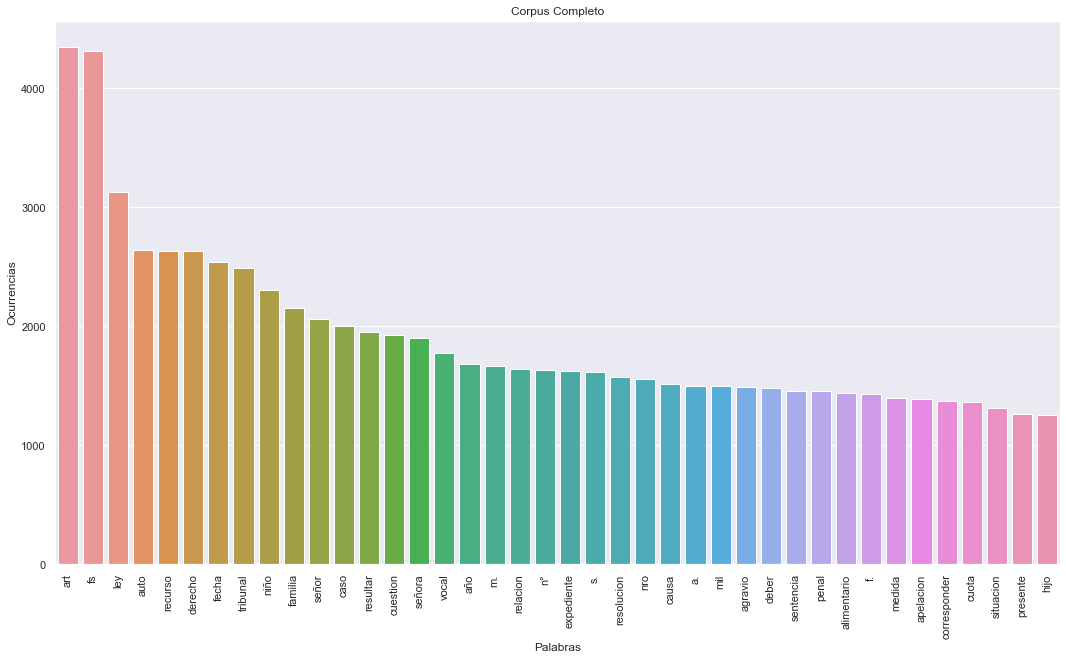

In [379]:
limit_to_plot=40

fig, axes = plt.subplots(1, 1 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes, x = "word" , y = "count", df = df_all ,title ="Corpus Completo" , limit_to_plot = limit_to_plot  )

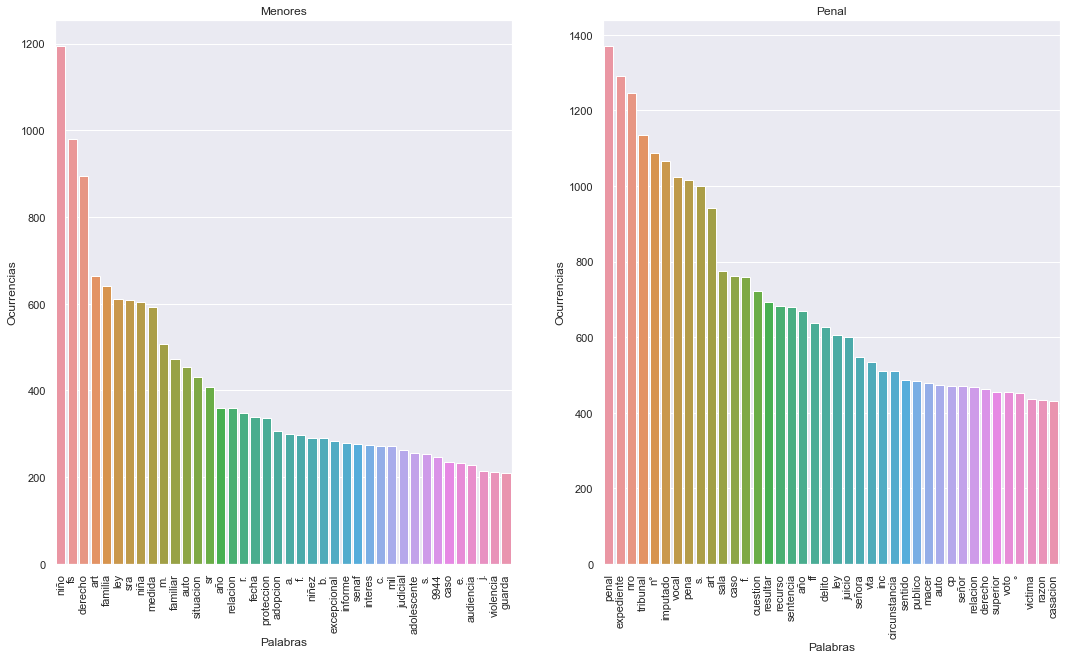

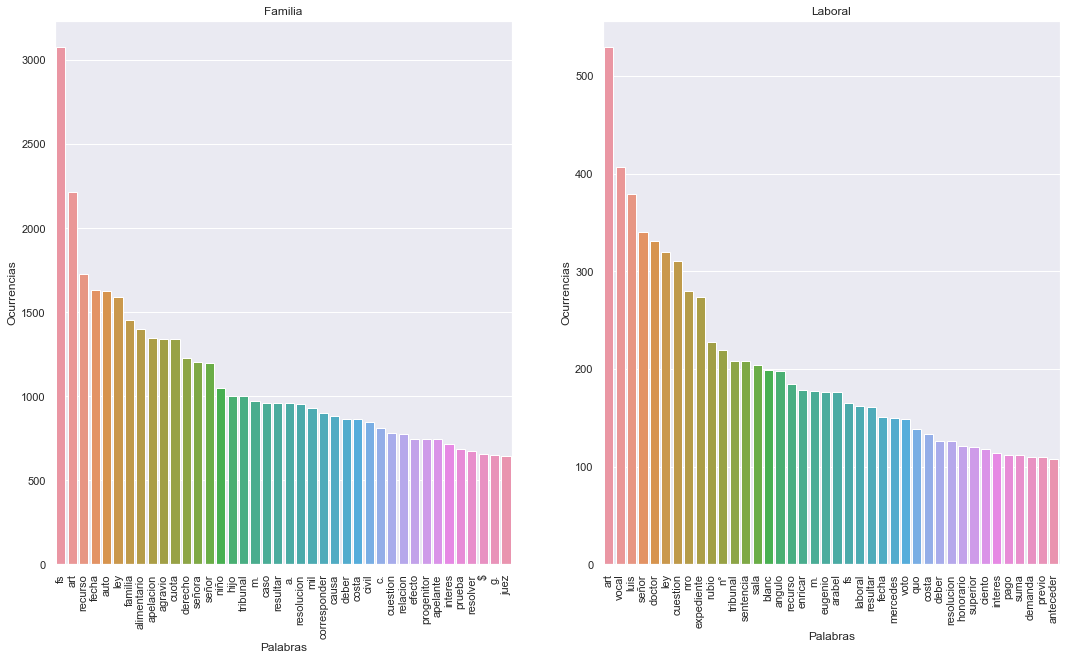

In [380]:
fig, axes = plt.subplots(1, 2 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_menores ,title ="Menores" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_penal ,title ="Penal" , limit_to_plot = limit_to_plot )


fig, axes = plt.subplots(1, 2 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_familia ,title ="Familia" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_laboral ,title ="Laboral" , limit_to_plot = limit_to_plot )

Se muestran gráficos de barras con la frecuencia bi y tri-gramas

In [381]:
timer.start()

df_menores_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 2] , 'Documentos/MENORES')
df_laboral_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 2] , 'Documentos/LABORAL')
df_penal_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 2] , 'Documentos/PENAL')
df_familia_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 2] , 'Documentos/FAMILIA')

timer.stop()

Tiempo de procesamiento: 0:00:41.609870


In [382]:
if True:
    
    timer.start()
    df_corpus_nagram.to_csv("corpus_ngram.csv")
    timer.stop()

Tiempo de procesamiento: 0:00:04.461050


In [383]:
df_menores[:10]

,word,count
5197,niño,1194
3634,fs,981
2459,derecho,894
1157,art,665
3456,familia,640
4680,ley,612
7070,sra,608
5194,niña,603
4945,medida,593
4786,m.,507


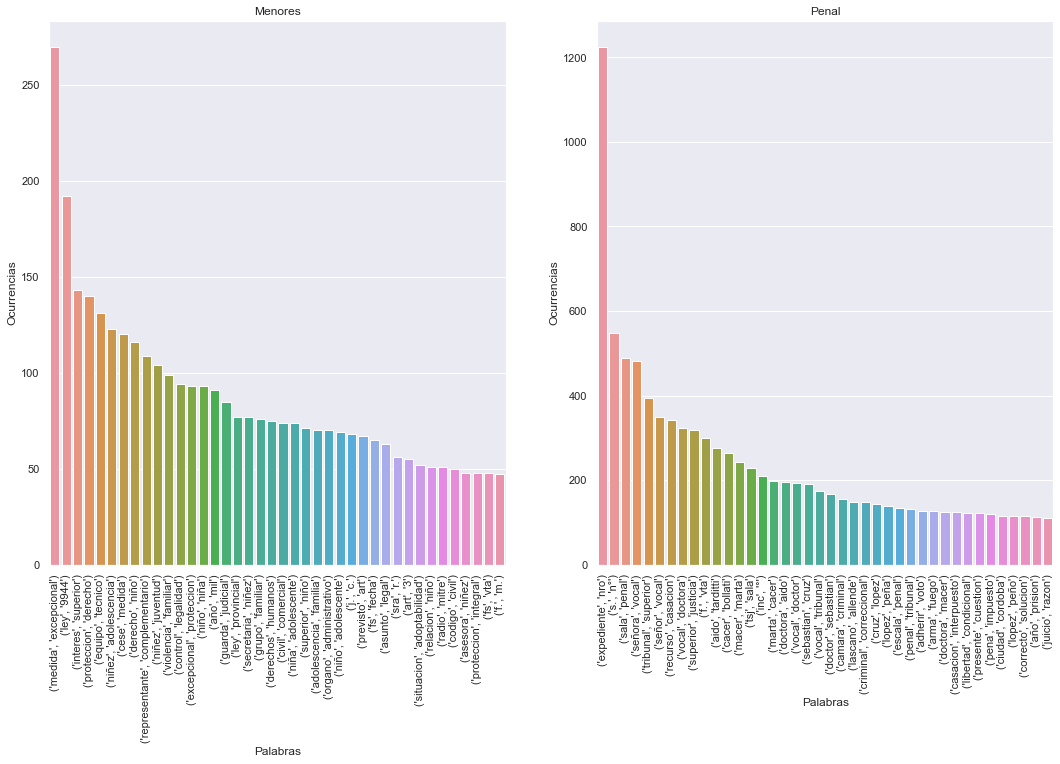

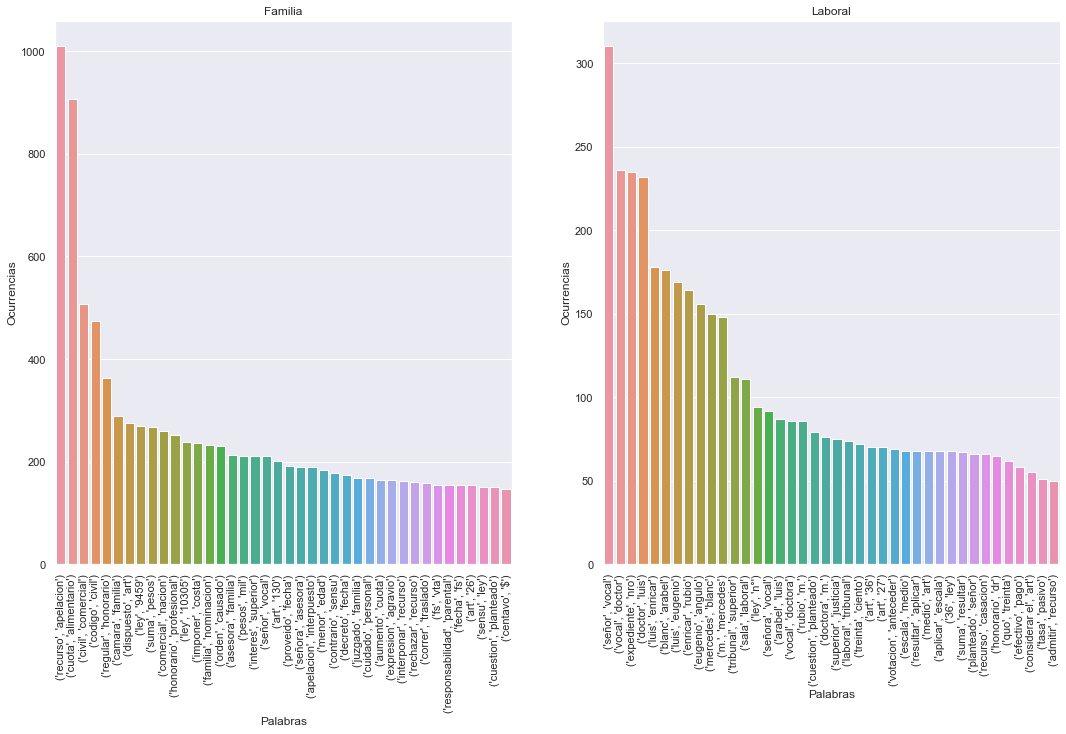

In [384]:
fig, axes = plt.subplots(1, 2 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_menores_ngram ,title ="Menores" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_penal_ngram ,title ="Penal" , limit_to_plot = limit_to_plot )


fig, axes = plt.subplots(1, 2 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_familia_ngram ,title ="Familia" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_laboral_ngram ,title ="Laboral" , limit_to_plot = limit_to_plot )

In [385]:
timer.start()

df_menores_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 3] , 'Documentos/MENORES')
df_laboral_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 3] , 'Documentos/LABORAL')
df_penal_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 3] , 'Documentos/PENAL')
df_familia_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 3] , 'Documentos/FAMILIA')

timer.stop()

Tiempo de procesamiento: 0:00:55.718014


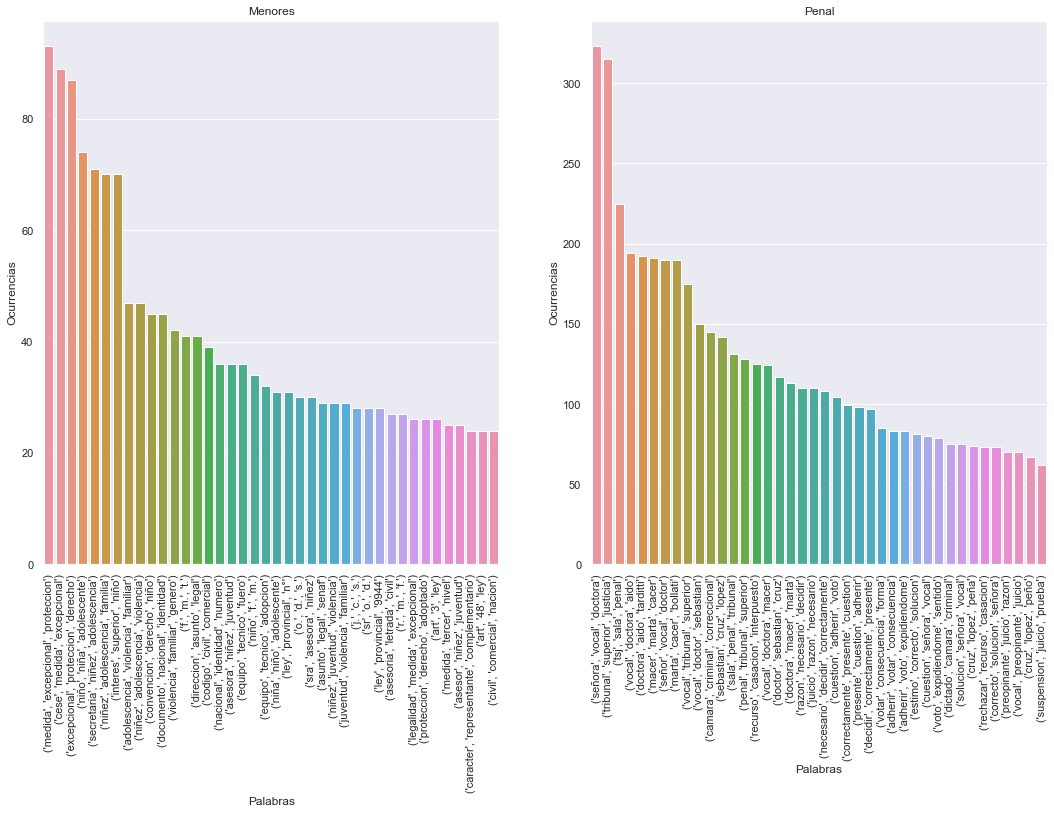

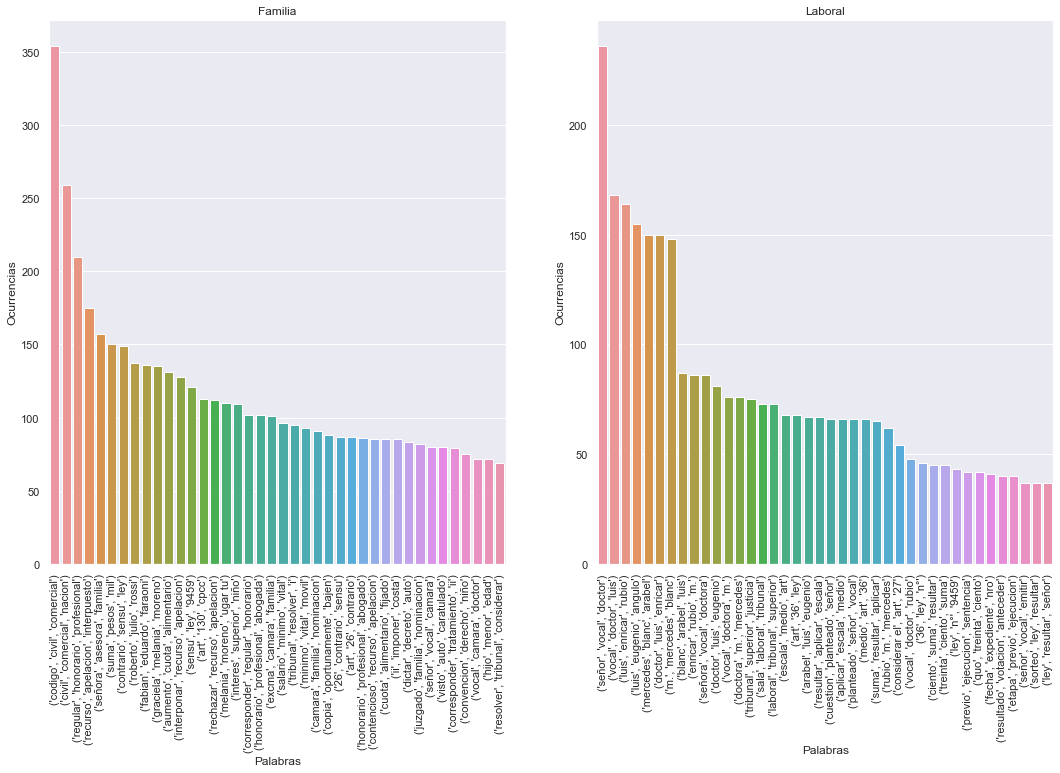

In [386]:
fig, axes = plt.subplots(1, 2 ,figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_menores_ngram ,title ="Menores" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_penal_ngram ,title ="Penal" , limit_to_plot = limit_to_plot )


fig, axes = plt.subplots(1, 2 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_familia_ngram ,title ="Familia" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_laboral_ngram ,title ="Laboral" , limit_to_plot = limit_to_plot )

Al utilizar bigramas y trigramas se puede observar que ciertos bigramas / trigamas son característicos para documentos de ciertos fueros. Por ejemplo  

- Familia:  “ cámara familia”, “recurso apleacion”, menores
- Menores: “medida excepcional” , “ley 9944”

Quizás al momento de entrenar modelos y/o redes neuronales, seria adecuado utilizar las palabras individuales y bigramas / trigramas

Al utilizar CountVectorizer, se nota:

- la existencia de una gran cantidad de números, muchos de ellos referidos a montos o sumas de dinero a pagar. Esto entendemos no suma información a los modelos y deben ser eliminados. El desarfío esta en conservar los números que representan leyes y articulos. El resto debería ser eliminado. Al realizar el CountVectorizer, se obtiene una matriz de 243x25929. Sacando todos los números, la matriz queda de 243x22320 <br><br>

- la existencia de fechas. Estas fechas entendemos que tampoco sumana información a los modelos y deben ser eliminados. (implementar eliminación)<br><br>

- la existencia de muchas palabras que tienen como prefixo y/o sufijo, el signo "-


Se ve un cambio significativo en cuanto a las palabras y ngramas mas frecuentes comparado con el práctico 1. Esto se debe en mayor medida a la eliminación de stop Words y las tranformaciones (Lemmatazing, cambio de caracteres como por ejemplo vocales con acento por vocales sin acentos) realizadas en el práctico 2


## Anexo

### Ejemplo Lemmatazing

Si bien durante la normalización de texto utilizamos lemmatazing, en este apartado dejamos un ejemplo de uso

In [31]:
#! conda install -y nltk

In [49]:
texto = [
    " Texto de prueba.",
    " Yo soy",
    " Tu eres", 
    " El es",
    " Los autos van a gran velocidad",
    " El auto va a gran velocidad."
    
    ]

doc_tuples = spacy_nlp.pipe(texto , as_tuples=False , n_process=-1  )

result = ""
lemmas = []
for doc in doc_tuples:
    for token in doc:
        result = result + " " + token.lemma_
    lemmas.append(result)
    result = ""
    
for f, b in zip(texto, lemmas):
    print(f" Texto original: {f} | Lema:{b}")
    

 Texto original:  Texto de prueba. | Lema:   Texto de prueba .
 Texto original:  Industria textil | Lema:   Industria textil
 Texto original:  Yo soy | Lema:   yo ser
 Texto original:  Tu eres | Lema:   tu ser
 Texto original:  El es | Lema:   el ser
 Texto original:  Los autos van a gran velocidad | Lema:   el auto ir a gran velocidad
 Texto original:  El auto va a gran velocidad. | Lema:   el auto ir a gran velocidad .


### Ejemplo Stemming

In [50]:
import nltk

In [51]:
#nltk.download()

In [52]:
from nltk.stem import PorterStemmer

In [53]:
porter = PorterStemmer()

In [54]:
for linea in texto:
    palabras = linea.split()
    for palabra in palabras:
        print (porter.stem(palabra))

texto
de
prueba.
industria
textil
Yo
soy
Tu
ere
El
es
lo
auto
van
a
gran
velocidad
El
auto
va
a
gran
velocidad.


In [400]:
from sklearn.feature_extraction.text import CountVectorizer

In [401]:
df_cleaned_corpus

,text,id,classifier
0,dato causa sede ciudad cordoba dependencia juz...,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES
1,univoco fecha materia niñez revista familia ni...,1f9cdcb2c2596656b540c1271fc2d843,Documentos/MENORES
2,juzgado niñez juventud violencia familiar 8ª n...,17dcae14592fc6e87680ccb4251d9395,Documentos/MENORES
3,auto caratulado a. a. denuncia violencia gener...,4b3ae58648b6267ebb332feec8002588,Documentos/MENORES
4,juzg niñez adolescencia violencia familiar 4ta...,1316026beaa1d7e6530bdfe7e54f7b5c,Documentos/MENORES
...,...,...,...
238,sala laboral tribunal superior protocolo sente...,5dec7fdd3bdeaafc1ec640e1582f5b08,Documentos/LABORAL
239,sala laboral tribunal superior protocolo sente...,5c1d6beee8e1f99f2959b430eba53fb1,Documentos/LABORAL
240,sala laboral tribunal superior protocolo sente...,b6682a594458229ec8b26e67ceab4cc2,Documentos/LABORAL
241,sala laboral tribunal superior protocolo sente...,a27c00c40e8fc4b357ec24780954f4b1,Documentos/LABORAL


In [412]:
count_vectorizer = CountVectorizer(tokenizer=str.split , token_pattern = ' ' , max_features = 100000 )
vector_matrix = count_vectorizer.fit_transform(df_cleaned_corpus['text'])
vector_matrix

<243x19503 sparse matrix of type '<class 'numpy.int64'>'
	with 199996 stored elements in Compressed Sparse Row format>

In [87]:
tokens = count_vectorizer.get_feature_names()
tokens

NameError: name 'count_vectorizer' is not defined